# Uncertainty with Bayesian Neural Networks

**Bayesian Neural Networks** (BNN) can be understood as a combination of neural networks and bayesian inference. In traditional deep learning, weights are fixed values (initially random), that we iteratively update via gradient descent. BNN on the other hand learn __distribution parameters over weights__, these distribution parameters are learned using bayesian inference. This approaches allows, among others, to measure uncertainty among predictions.

# Bayesian inference 

In bayesian inference we try to compute $p(w | D_{train})$, the conditional distribution of the weights given the data, aka the *posterior distribution*, rather than static parameters values. 

### Exact Bayesian Inference

Thanks to Bayes' rule we can compute the posterior : 

\begin{align*}
    p(w | D) & = \frac{p(D | w)p(w)}{p(D)}\\
             & = \frac{p(D | w)p(w)}{\int_w' p(D | w')p(w')} \\
\end{align*}

With $\hat{y}$ the predicted output as a function of the input $x$, The posterior distribution over the weights allows us to compute the __predictive distribution__ : 

\begin{align*}
    p(\hat{y}(x) | D) = \int_w p(\hat{y}(x) | w) p(w | D) dw = \mathbb{E}_{p(w | D)} [p(\hat{y}(x) | w)]
\end{align*}

which can be useful to describe the epistemic uncertainty of our model. We will come back later on the uncertainty.

Computing the posterior in this way can be called *exact inference*, and needs the *prior* $p(w)$ and the *likelihood* $p(D | w)$ of the data. Unfortunately in the expression of the posterior and the predictive distribution we need to integrate over the weight space which can be intractable, in order to adresses theses issues we use a set of tools that allow us to do approximate inference. There is two family of approximate inference methods : sampling and variational, we will focus on variational methods.

### Variational inference

The spirit of variational inference is, when facing an intractable posterior $p(w | D)$, to surrogate it with a parametrized distribution $q_{\phi}(w)$, namely the *approximate posterior*. This surrogate distribution will be optimised (by tuning its parameters $\phi$) in order to be as close as possible to the original posterior. In practice the choice of the approximate distribution can be seen as an hyperparameter. Two main questions arise from this : 

* **How to check if the surrogate is close to the true posterior ?** 
* **How to maximize the similarity of our distributions ?**


### Measure of similarity : 

The Kullback-Liebler divergence is a metric that allows us to mesure the similiarity between two distribution. it is defined by the expectation of the log ratio between the two distributions : 

\begin{align*}
    D_{KL}(P \| Q) = \mathbb{E} \left[log \frac{P}{Q}\right]
\end{align*}

in our case : 

\begin{align*}
    D_{KL} (q_{\phi}(w) \| p(w | D)) & = \mathbb{E}_{q_{\phi}(w)}\left[log \frac{q_{\phi}(w)}{p(w |D)} \right] \\
                                    & = \int_w q_\phi (w) log \frac{q_\phi (w)}{p(w |D)}
\end{align*}


The KL divergence is a non-negative measure of similarity, that is 0 for identical distributions
... 

### Derive a tractable optimization problem : 

We have an intractable posterior $p(w | W)$, a surrogate distribution $q_{\phi}(w)$, a way to measure their similarity  $D_{KL} (q_{\phi}(w) \| p(w | D))$, now we need find a way to minimize their dissimilarity. To do this we will formulate it as an optimization problem. 

Directly minimizing  $D_{KL} (q_{\phi}(w) \| p(w | D))$ is 
difficult as $p(w | D)$ is still intractable. To bypass this we will derive a related quantity, equal to the KL divergence plus a constant, that will be our new objective.

\begin{align*}
    D_{KL} (q_{\phi}(w) \| p(w | D)) & = \mathbb{E}_{q_{\phi}(w)}\left[log \frac{q_{\phi}(w)}{p(w |D)} \right] \\
                                     & = \mathbb{E}_{q_{\phi}(w)}\left[log(q_{\phi}(w)) - log (p(w |D)) \right] \\
                                     & = \mathbb{E}_{q_{\phi}(w)}\left[log(q_{\phi}(w))\right] - \mathbb{E}_{q_{\phi}(w)}\left[log (p(D, w)) - log (p(D)) \right] \\        
                                     & = \mathbb{E}_{q_{\phi}(w)}\left[log(q_{\phi}(w))\right] - \mathbb{E}_{q_{\phi}(w)}\left[log (p(D, w))\right] + log p(D)\\                   
\end{align*}

thus 

\begin{align*} 
    log p(D) \geq \mathbb{E}_{q_{\phi}(w)}\left[log q_{\phi}(w) - log p(w, D)\right] \;\;\;\;\;\;\;\; \;\;\;\;\;\;\;\;\; [\small{\text{as}\;\;\; D_{KL}(q \| p) \geq 0}]
\end{align*}

## Make it work with neural networks.
### bayes by backprop

Once our optimization problem formulated we want to be able to optimize it, and in the context of neural networks, using gradient descent. Hence we need a proper algortihm adapted for backpropagation. To do so we will use bayes by backpropagation, a backpropagation compatible algorithm for learning a probability distribution on the weights of a neural network. \cite{Blundell et al.}. 

In bayesian neural networks, it is challenging to differentiate random nodes. To overcome this we will use a tool called the reparametrization trick. Intuitively, the reparametrization trick allows to flow gradient through random nodes by moving the randomness outside of the node, rending it deterministic. As such, backprop can be applied to our variational parameter $\phi$. This gives us the advantage of maintaining a training loop analogous to that of a standard neural network, which is convenient as it permits the use of traditional optimizers, such as Adam.

More formally, considering a gaussian posterior distribution $q_{\phi}(z|x)$, parametrized by $\mu$ and $\sigma$. say we want to minimize a loss function $E_{q_{\phi}(z | x)} [f(z))]$. 
Directly optimizing this expectation with respect to $\phi$ can be difficult due to its randomness in z complicating the computation of gradients. To overcome this we introduce an auxilary variable $\epsilon$ drawn from a distribution $p(\epsilon)$ independent from $\phi$ allowing us to express z as a deterministic function of $\phi$ and $\sigma$ such as $z = g_{\phi}(\epsilon, x) = \mu(x; \mu) + \sigma(w, \phi) \otimes \epsilon$. Typically $\epsilon$ is drawn from Gaussian ditribution $\epsilon \sim \mathcal{N}(0, I)$. Thus the expectation turns into : 

\begin{align*}
    \nabla_{\phi} E_{p(\epsilon)}[f(g_{\phi}(\epsilon, x))] &= E_{p(\epsilon)}[ \nabla_{\phi} f(g_{\phi}(\epsilon, x))] 
\end{align*} 

# Import, data and utils functions 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

# Dataset

- Basic non-linear dataset for a classification problem

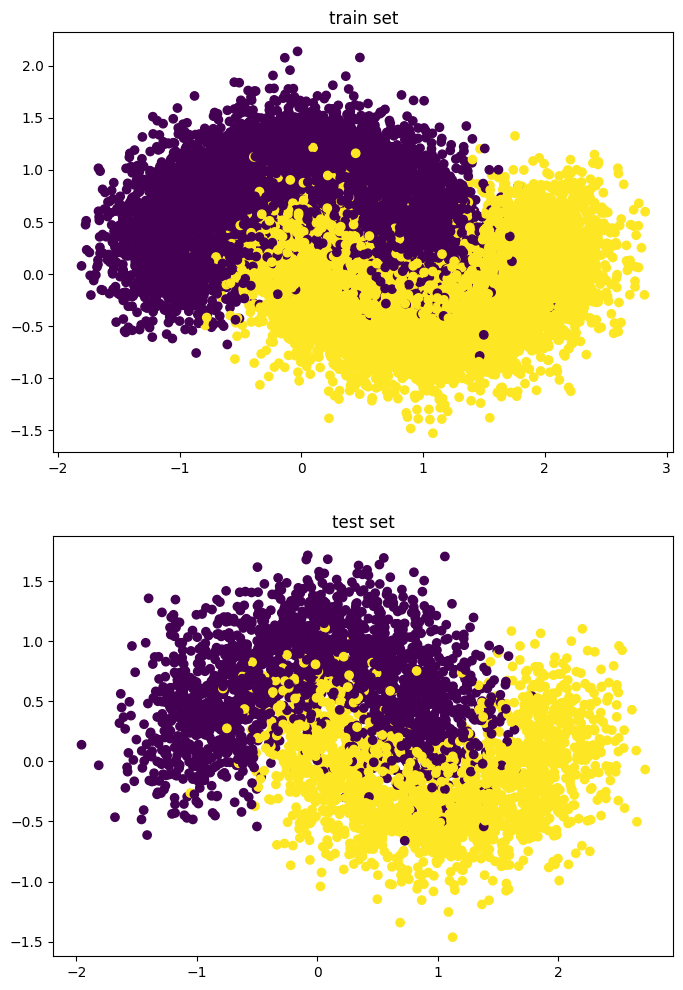

In [5]:
X, y = make_moons(n_samples=20000, noise=0.3)
y = y.reshape(-1,1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_test = tf.cast(X_test, tf.float32)
X_train = tf.cast(X_train, tf.float32)
y_test = tf.cast(y_test, tf.float32)
y_train = tf.cast(y_train, tf.float32)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
ax1.scatter(X_train[:,0], X_train[:,1], c=y_train)
ax1.set_title('train set')
ax2.scatter(X_test[:,0], X_test[:,1], c=y_test)
ax2.set_title('test set')

plt.show()

# Baseline model
traditional deep net

In [6]:
def create_network(units=100, activation='relu', lr=0.01) : 
    
    inputs = keras.Input(shape=(X_train.shape[1],))
    
    hidden1 = Dense(units, activation=activation)(inputs)
    hidden1 = BatchNormalization()(hidden1)
    
    hidden2 = Dense(units, activation=activation)(hidden1)
    hidden2 = BatchNormalization()(hidden2)
    
    hidden3 = Dense(units, activation=activation)(hidden2)
    hidden3 = BatchNormalization()(hidden3)
    
    outputs = Dense(1, activation='sigmoid')(hidden3)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='baseline')

    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['Accuracy'])
    model.summary()
    return model

In [7]:
baseline = create_network()
baseline.fit(X_train, y_train, batch_size=32, verbose=0, epochs=20) 

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 100)               300       
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 100)               101

- Evaluate the model

accuracy :  0.902


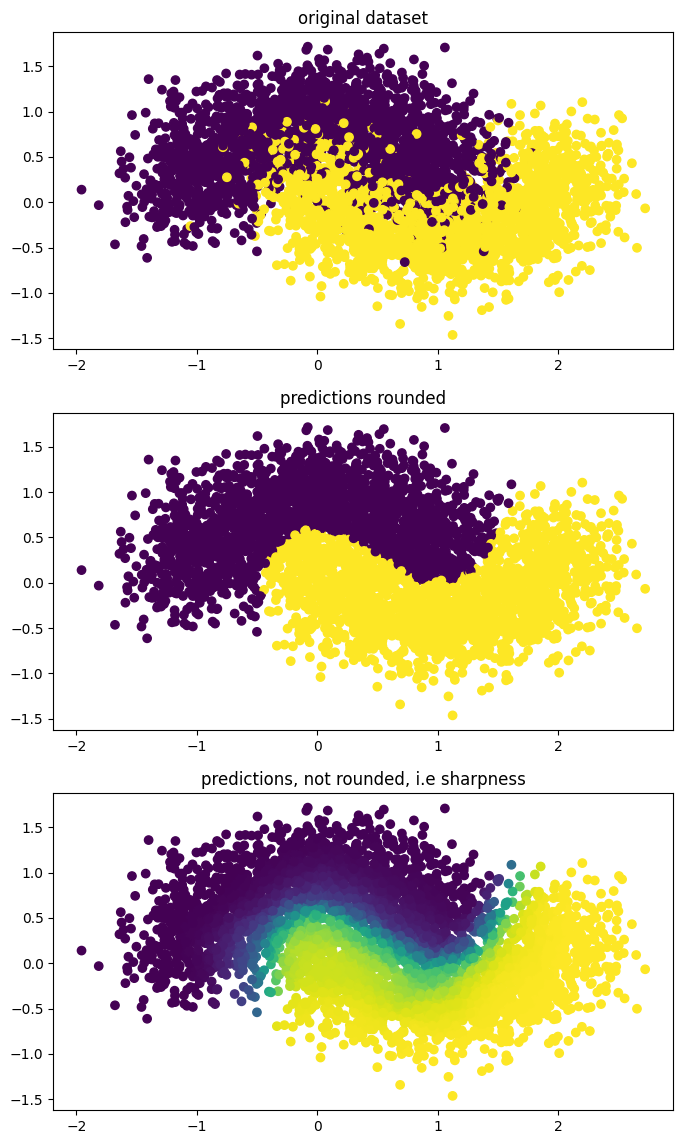

In [15]:
y_pred = np.asarray(baseline(X_test))

print('accuracy : ', accuracy_score(y_test, y_pred.round()))

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(8, 14))
ax1.scatter(X_test[:,0], X_test[:,1], c=y_test)
ax1.set_title('original dataset')

ax2.scatter(X_test[:,0], X_test[:,1], c=y_pred.round())
ax2.set_title('predictions rounded')

ax3.scatter(X_test[:,0], X_test[:,1], c=y_pred)
ax3.set_title('predictions, not rounded, i.e sharpness')

plt.show()

The sharpness of the predictions can already give a sense of uncertainty of the model on its predictions.

* ### Aleatoric uncertainty (aka statistical) : 
Aleatoric uncertainty refers to the notion of randomness, That is the uncertainty rising from the datahimself, where the model cannot act.

To allow a model to capture the aleatoric uncertainty we will output not a point estimate as usual but a probability distribution. In the case of binary classification the output will be a bernoulli distribution. 

$
    \mathbb{P}(X = x) = p^x(1 - p)^{1-x},\;\; x \in [0, 1]
$

As the output is no more a single estimate we need to change the loss function, we will use the **negative loglieklihood**, in order to get how likely it is to encounter targets in our data from the estimated distribution of the model.

In [11]:
def nll(y, y_pred): 
  return -y_pred.log_prob(y)

In practice the only modification to our baseline model is the ouput layer. In our case we will use a *IndependentBernoulli* layer.

In [12]:
def create_aleatoric_model(units=100, activation='relu', lr=0.001):

  inputs = keras.Input(shape=(X_train.shape[1],))

  hidden1 = Dense(units, activation=activation)(inputs)
  hidden1 = BatchNormalization()(hidden1)
  hidden1 = Dropout(0.1)(hidden1)

  hidden2 = Dense(units, activation=activation)(hidden1)
  hidden2 = BatchNormalization()(hidden2)
  hidden2 = Dropout(0.1)(hidden2)
  
  hidden3 = Dense(units, activation=activation)(hidden2)
  hidden3 = BatchNormalization()(hidden3)
  hidden3 = Dropout(0.1)(hidden3)

  # output Bernoulli distribution  
  outputs = Dense(tfp.layers.IndependentBernoulli.params_size(1))(hidden3)  
  outputs = tfp.layers.IndependentBernoulli(1)(outputs)

  model = keras.Model(inputs=inputs, outputs=outputs, name='aleatoric_BNN')

  opt = keras.optimizers.Adam(learning_rate=lr)
  model.compile(loss=nll, optimizer=opt, metrics=['Accuracy'])
  model.summary()
  return model

In [13]:
aleatoric_model = create_aleatoric_model()
aleatoric_model.fit(X_train, y_train, batch_size=32, verbose=0, epochs=20) 

Model: "aleatoric_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 100)               300       
                                                                 
 batch_normalization_3 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_4 (Bat  (None, 100)               400       
 chNormalization)                                    

**The standard deviation of the outputed distribution will represent te aleatoric uncertainty associated with the dataset :**

accuracy :  0.9025


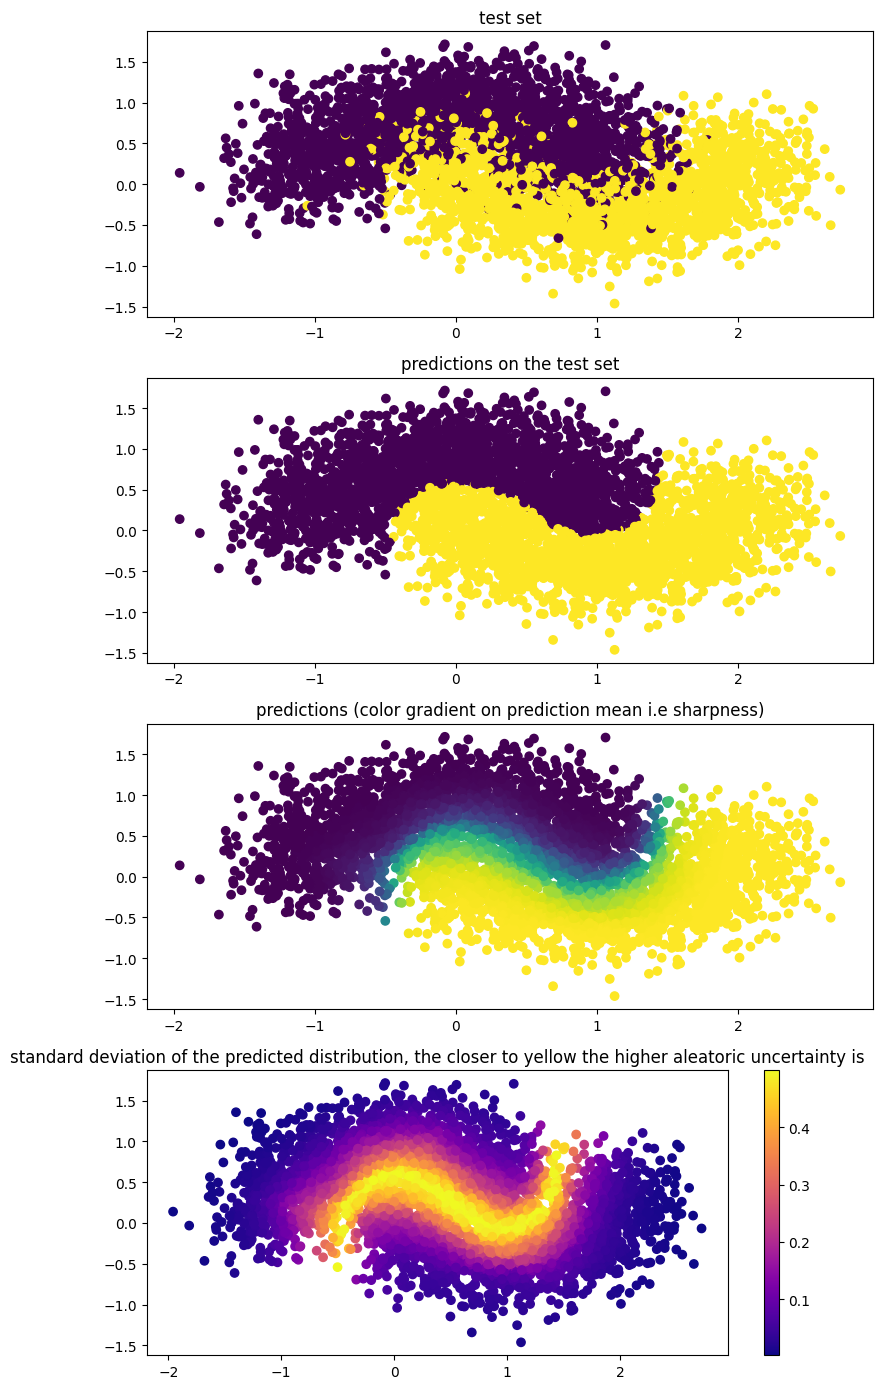

In [14]:
pred_distribution = aleatoric_model(X_test)
pred_mean = pred_distribution.mean().numpy()
pred_stdv = pred_distribution.stddev().numpy()

print('accuracy : ', accuracy_score(y_test, pred_mean.round()))

fig, axs = plt.subplots(4, 1, figsize=(8,14))
axs[0].scatter(X_test[:,0], X_test[:,1], c=y_test)
axs[0].set_title('test set')
axs[1].scatter(X_test[:,0], X_test[:,1], c=pred_mean.round())
axs[1].set_title('predictions on the test set')
axs[2].scatter(X_test[:,0], X_test[:,1], c=pred_mean)
axs[2].set_title('predictions (color gradient on prediction mean i.e sharpness)')
points2 = axs[3].scatter(X_test[:,0], X_test[:,1], c=pred_stdv, cmap='plasma')
axs[3].set_title('standard deviation of the predicted distribution, the closer to yellow the higher aleatoric uncertainty is')

fig.colorbar(points2)

plt.tight_layout()

* ### Epistemic uncertainty (aka systematic) : 
refers to uncertainty caused by a lack of knowledge. It can be seen as the uncertainty of the model itself on his predictions. The epistemic uncertainty is the ability of the model saying 'I don't know'.

In practice, we will use tfp ```DenseVariational``` layers to do variational inference. Recall variational inference relies on Bayesian inference. Thus we need to define a prior $p(w)$ and a posterior distribution $p(w|D)$. The choice of these distributions can be seen as hyperparameters. Prior are imortant as they have a regularization aspect.  Here are listed a few options available with tfp :  

### Priors

* Normal (or Gaussian) prior
  
A basic reasonable approach is a normal prior distribution.  The normal prior acts as a form of regularization, penalizing large weights by making them less probable a priori. This is analogous to L2 regularization (or Ridge regression) in frequentist statistics, where the penalty on the weights is proportional to their squared magnitude.

The normal prior promotes smoothness and smaller magnitudes in the weights but does not explicitly push them to zero. This can lead to models that are less sparse but potentially more stable, as small changes in the input data are less likely to result in large changes in the output.

In [24]:
def normal_prior(kernel_size, bias_size, dtype=None): 
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
    [
          tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=tf.zeros(n),
                       scale=2*tf.ones(n)), 
          reinterpreted_batch_ndims=1)),
    ])
    return prior_model

* Multivariate Normal prior 

As opposed to independent normal priors, where each connexion has its own independent distribution, a mutlivariate normal distribution assigns weights to each neurones of a layer and this thus useful to capture correlation between weights.

In [12]:
def multivariate_normal_prior(kernel_size, bias_size, dtype=None): 
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfd.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

* Laplace prior

the Laplace prior induces sparsity in a more direct manner. It is analogous to L1 regularization (or the Lasso method) in frequentist statistics.

The Laplace prior encourages sparsity in the model parameters by having a sharp peak at zero and heavy tails. This means that it pushes coefficients towards exactly zero, effectively performing variable selection or feature elimination, which can be beneficial in models with many irrelevant features.

In [25]:
def laplace_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size # num of params
    return Sequential([
       tfp.layers.DistributionLambda(
           lambda t: tfd.Independent(tfd.Laplace(loc = tf.zeros(n), 
                                                 scale=tf.ones(n)),
                                     reinterpreted_batch_ndims=1))               
  ])

* Horseshoe prior

The Horseshoe prior introduces a form of regularization that is more adaptive compared to traditional techniques like L1 or L2 regularization. It can shrink less relevant weights more aggressively towards zero while allowing important weights to remain large, potentially leading to a more sparse and efficient network. It can be used aswell to prune the network by shifting useless connexions towards 0.

In [26]:
def horseshoe_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size # num of params
    return Sequential([
       tfp.layers.DistributionLambda(
           lambda t: tfd.Independent(tfd.Horseshoe(scale = tf.zeros(n),
                                                   reinterpreted_batch_ndims=1)))               
  ])

### Posteriors

In variational inference, using a independent normal distribution is a common practice as it ensures mathematical conveniance. They also enable the use of the reparametrization trick, allowing gradient estimations.

In [16]:
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=tf.nn.softplus(t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

In [21]:
def posterior(kernel_size, bias_size, dtype=None): 
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    
    return posterior_model

In [28]:
def posterior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.IndependentNormal.params_size(n), dtype=dtype
            ),
            tfp.layers.IndependentNormal(n),
        ]
    )
    
  return posterior_model

## Epistemic model

In [29]:
def create_epistemic_model(prior, posterior):
  inputs = keras.Input(shape=(X_train.shape[1],))

  x = tfp.layers.DenseVariational(units=200, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='relu')(inputs)
  
  x = tfp.layers.DenseVariational(units=200, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='relu')(x)
                        
  outputs = tfp.layers.DenseVariational(units=1, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='sigmoid')(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name='epistemic_BNN')

  opt = keras.optimizers.Adam(learning_rate=0.001)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=opt, metrics=['Accuracy'])
  model.summary()

  return model

In [30]:
epistemic_model = create_epistemic_model(multivariate_normal_prior, posterior)
epistemic_model.fit(X_train, y_train, batch_size=32, verbose=0, epochs=500) 

Model: "epistemic_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_variational_3 (Dense  (None, 200)               1200      
 Variational)                                                    
                                                                 
 dense_variational_4 (Dense  (None, 200)               80400     
 Variational)                                                    
                                                                 
 dense_variational_5 (Dense  (None, 1)                 402       
 Variational)                                                    
                                                                 
Total params: 82002 (320.32 KB)
Trainable params: 82002 (320.32 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [31]:
def infer(X, y, model_, it=10): 
  y_preds = []
  for _ in range(it): 
    y_preds.append(model_(X))
  
  pred_mean = np.mean(y_preds, axis=0)
  pred_stdv = np.std(y_preds, axis=0)
  
  print('accuracy : ', accuracy_score(y, pred_mean.round()))

  return pred_mean, pred_stdv

accuracy :  0.90375


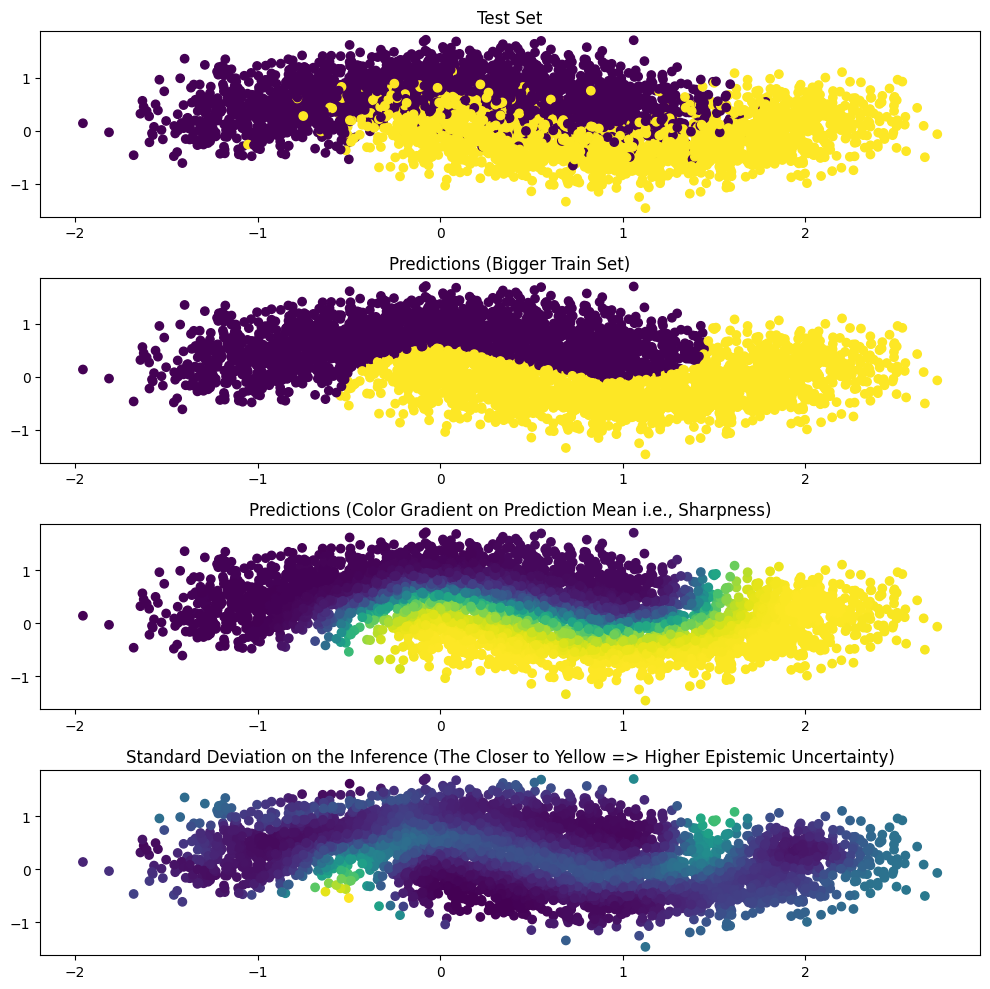

In [34]:
pred_mean, pred_stdv = infer(X_test, y_test, epistemic_model, 100)

fig = plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1) 
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
plt.title('Test Set')

plt.subplot(4, 1, 2) 
plt.scatter(X_test[:,0], X_test[:,1], c=pred_mean.round())
plt.title('Predictions (Bigger Train Set)')

plt.subplot(4, 1, 3) 
plt.scatter(X_test[:,0], X_test[:,1], c=pred_mean)
plt.title('Predictions (Color Gradient on Prediction Mean i.e., Sharpness)')

plt.subplot(4, 1, 4) 
plt.scatter(X_test[:,0], X_test[:,1], c=pred_stdv)
plt.title('Standard Deviation on the Inference (The Closer to Yellow => Higher Epistemic Uncertainty)')

plt.tight_layout()
plt.show()


## Epistemic regression

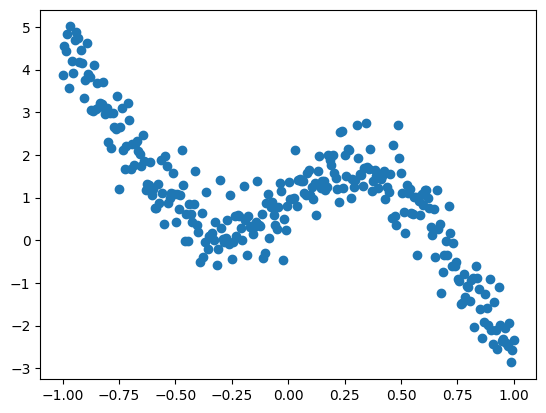

In [3]:
X = np.linspace(-1, 1, 300)
y = 4 * X * np.cos(np.pi * np.sin(X)) + 1 + np.random.randn(X.shape[0]) * 0.5
plt.scatter(X, y)
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

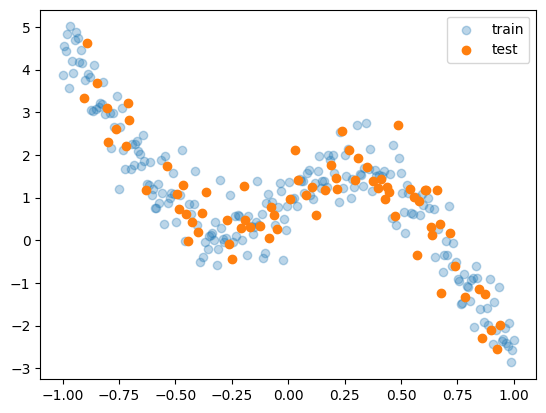

In [7]:
plt.scatter(X_train, y_train, alpha=0.3, label='train')
plt.scatter(X_test, y_test, label='test')
plt.legend()
plt.show()

In [11]:
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(

          tfd.Normal(loc=t[..., :n],
                     scale= 1e-5 + 0.003 * tf.nn.softplus(t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

In [13]:
def epistemic_regressor(prior, posterior):
  inputs = keras.Input(shape=(1,))

  x = tfp.layers.DenseVariational(units=128, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='relu')(inputs)
  
  x = tfp.layers.DenseVariational(units=64, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='relu')(x)
                    
  outputs = tfp.layers.DenseVariational(units=1, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0])(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name='epistemic_BNN')

  opt = keras.optimizers.Adam(learning_rate=0.001)

  model.compile(loss='mse', optimizer=opt)
  model.summary()

  return model
  

In [15]:
regressor = epistemic_regressor(multivariate_normal_prior, posterior)
regressor.fit(X_train, y_train, verbose=0, batch_size=32, epochs=3000)

Model: "epistemic_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_variational_3 (Dense  (None, 128)               512       
 Variational)                                                    
                                                                 
 dense_variational_4 (Dense  (None, 64)                16512     
 Variational)                                                    
                                                                 
 dense_variational_5 (Dense  (None, 1)                 130       
 Variational)                                                    
                                                                 
Total params: 17154 (67.01 KB)
Trainable params: 17154 (67.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________

Epoch 1761/2000
8/8 [==============================] - 0s 4ms/step - loss: 576306.6250 - val_loss: 576664.1250
Epoch 1762/2000
8/8 [==============================] - 0s 4ms/step - loss: 577105.4375 - val_loss: 577484.8125
Epoch 1763/2000
8/8 [==============================] - 0s 4ms/step - loss: 576837.5000 - val_loss: 576796.6250
Epoch 1764/2000
8/8 [==============================] - 0s 4ms/step - loss: 576990.6250 - val_loss: 577447.9375
Epoch 1765/2000
8/8 [==============================] - 0s 4ms/step - loss: 576647.7500 - val_loss: 577576.1875
Epoch 1766/2000
8/8 [==============================] - 0s 4ms/step - loss: 576674.5000 - val_loss: 575671.0000
Epoch 1767/2000
8/8 [==============================] - 0s 4ms/step - loss: 575940.5625 - val_loss: 575026.7500
Epoch 1768/2000
8/8 [==============================] - 0s 4ms/step - loss: 575004.9375 - val_loss: 573340.6875
Epoch 1769/2000
8/8 [==============================] - 0s 4ms/step - loss: 575943.4375 - val_loss: 574569.6250
E

Epoch 1835/2000
8/8 [==============================] - 0s 4ms/step - loss: 563635.5625 - val_loss: 567140.1875
Epoch 1836/2000
8/8 [==============================] - 0s 4ms/step - loss: 563307.9375 - val_loss: 562122.7500
Epoch 1837/2000
8/8 [==============================] - 0s 4ms/step - loss: 563907.0625 - val_loss: 559996.8125
Epoch 1838/2000
8/8 [==============================] - 0s 4ms/step - loss: 564540.1875 - val_loss: 564405.5000
Epoch 1839/2000
8/8 [==============================] - 0s 4ms/step - loss: 564496.8750 - val_loss: 564952.8125
Epoch 1840/2000
8/8 [==============================] - 0s 4ms/step - loss: 564269.3750 - val_loss: 563882.7500
Epoch 1841/2000
8/8 [==============================] - 0s 4ms/step - loss: 563042.2500 - val_loss: 561661.2500
Epoch 1842/2000
8/8 [==============================] - 0s 4ms/step - loss: 563169.8750 - val_loss: 564137.9375
Epoch 1843/2000
8/8 [==============================] - 0s 4ms/step - loss: 563015.3750 - val_loss: 561858.2500
E

Epoch 1909/2000
8/8 [==============================] - 0s 4ms/step - loss: 553002.6250 - val_loss: 553562.5000
Epoch 1910/2000
8/8 [==============================] - 0s 4ms/step - loss: 550072.6875 - val_loss: 552572.6875
Epoch 1911/2000
8/8 [==============================] - 0s 4ms/step - loss: 551170.6875 - val_loss: 549317.1875
Epoch 1912/2000
8/8 [==============================] - 0s 4ms/step - loss: 550275.8125 - val_loss: 549150.9375
Epoch 1913/2000
8/8 [==============================] - 0s 4ms/step - loss: 550419.6875 - val_loss: 551873.2500
Epoch 1914/2000
8/8 [==============================] - 0s 4ms/step - loss: 551007.1875 - val_loss: 549316.8750
Epoch 1915/2000
8/8 [==============================] - 0s 4ms/step - loss: 550401.7500 - val_loss: 548997.8125
Epoch 1916/2000
8/8 [==============================] - 0s 4ms/step - loss: 549887.4375 - val_loss: 548378.5625
Epoch 1917/2000
8/8 [==============================] - 0s 4ms/step - loss: 549509.5625 - val_loss: 550903.8125
E

Epoch 1983/2000
8/8 [==============================] - 0s 4ms/step - loss: 539521.8750 - val_loss: 540367.8125
Epoch 1984/2000
8/8 [==============================] - 0s 4ms/step - loss: 538468.9375 - val_loss: 539752.5625
Epoch 1985/2000
8/8 [==============================] - 0s 4ms/step - loss: 537164.2500 - val_loss: 538776.0000
Epoch 1986/2000
8/8 [==============================] - 0s 4ms/step - loss: 539270.0625 - val_loss: 539925.4375
Epoch 1987/2000
8/8 [==============================] - 0s 4ms/step - loss: 538661.3750 - val_loss: 537635.8125
Epoch 1988/2000
8/8 [==============================] - 0s 4ms/step - loss: 539571.7500 - val_loss: 539656.6875
Epoch 1989/2000
8/8 [==============================] - 0s 4ms/step - loss: 537331.1875 - val_loss: 537959.0625
Epoch 1990/2000
8/8 [==============================] - 0s 4ms/step - loss: 537211.8125 - val_loss: 537631.8125
Epoch 1991/2000
8/8 [==============================] - 0s 4ms/step - loss: 537210.3125 - val_loss: 535850.0000
E

In [16]:
regressor.evaluate(X_test, y_test)

3/3 [==============================] - 1s 4ms/step - loss: 86.7515


86.75151062011719

Text(0.5, 1.0, 'Epistemic uncertainty in regression')

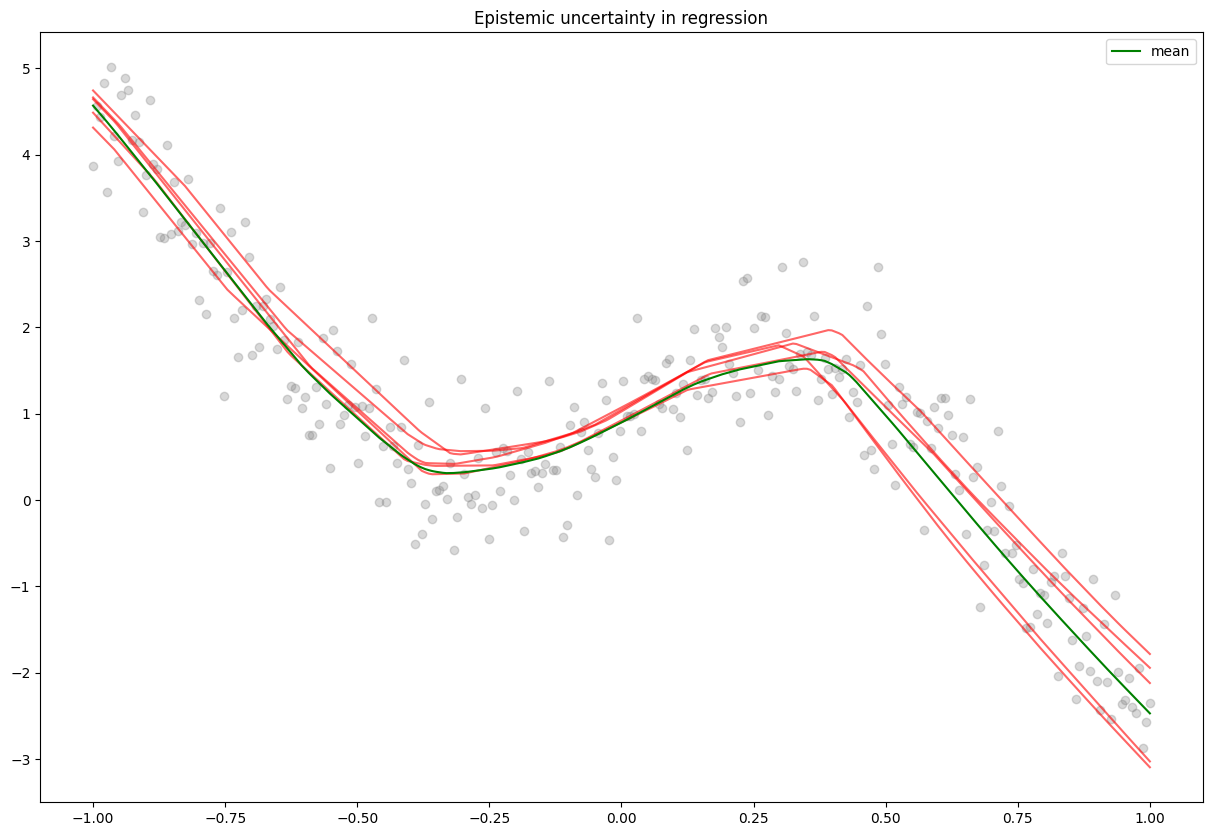

In [18]:
plt.figure(figsize=(15, 10))
plt.scatter(X, y, marker='o', color='gray', alpha=0.3)
y_pred = 0
for _ in range(5):
  y_pred +=  regressor(X)
  plt.plot(X, regressor(X), color='red', alpha=0.6)

plt.plot(X, y_pred/5, color='green', label='mean')
plt.legend()
plt.title('Epistemic uncertainty in regression')